In [1]:
!pip install transformers torchaudio librosa soundfile


In [5]:
import torch
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


In [3]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 6.4 MB/s eta 0:00:00


In [6]:
!pip install phonemizer
!apt-get install -y espeak-ng


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 48.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
The following NEW packages will be installed:
  espeak-ng espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 2 not upgraded.
Need to get 4,526 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpcaudio0 amd64 1.1-6build2 [8,956 B]
Get:2 http://archive.ubun

In [9]:
import os

os.listdir("/content")


['.config', 'LJ050-0274.wav', 'sample_data']

In [10]:
audio_path = "/content/LJ050-0274.wav"
signal, sr = librosa.load(audio_path, sr=16000, mono=True)

print("Sample Rate:", sr)
print("Duration (seconds):", len(signal)/sr)


Sample Rate: 16000
Duration (seconds): 4.5001875


In [3]:
processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-lv-60-espeak-cv-ft"
)

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-lv-60-espeak-cv-ft"
)

model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [11]:
inputs = processor(
    signal,
    sampling_rate=sr,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
phoneme_sequence = processor.batch_decode(predicted_ids)[0]

print("Recognized Phonemes:")
print(phoneme_sequence)


Recognized Phonemes:
m eɪ d s ɜː t ə n ɹ ɛ k ə m ə n d eɪ ʃ ə n z w ɪ tʃ ɪ t b ᵻ l iː v z w ʊ d ɪ f ɐ d ɑː p t ᵻ d


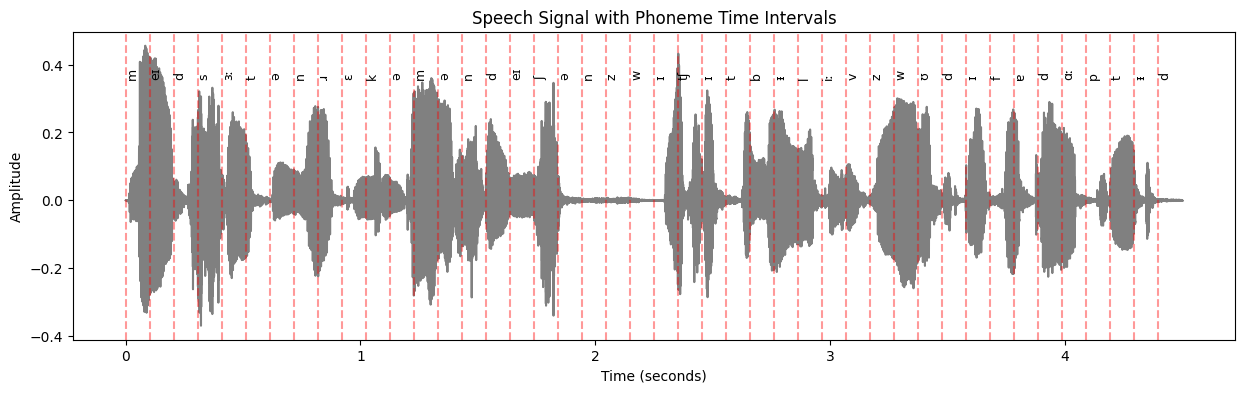

In [15]:
time = np.arange(len(signal)) / sr

plt.figure(figsize=(15,4))
plt.plot(time, signal, color='gray')
plt.title("Speech Signal with Phoneme Time Intervals")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")

for ph, start, end in phoneme_intervals:
    plt.axvline(x=start, color='red', linestyle='--', alpha=0.4)
    plt.text(start, 0.8*np.max(signal), ph, rotation=90, fontsize=9)

plt.show()


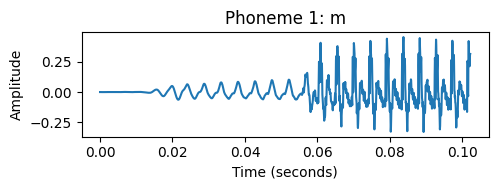

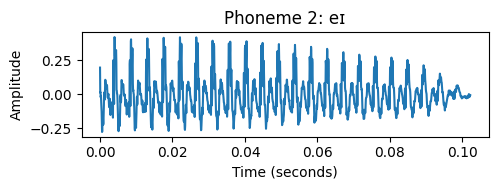

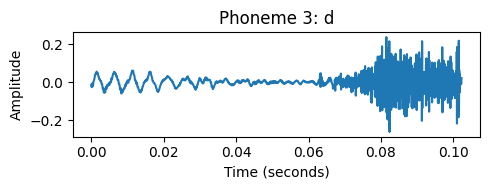

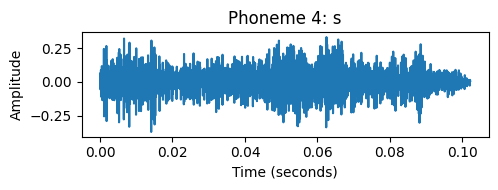

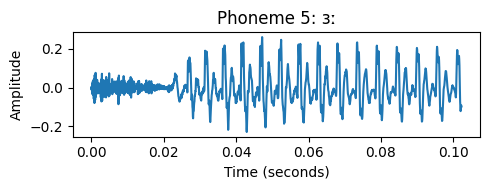

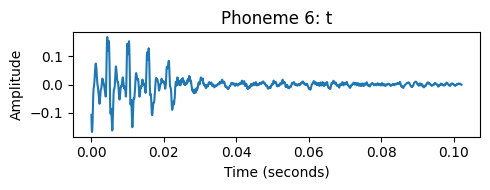

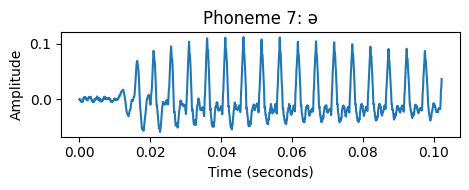

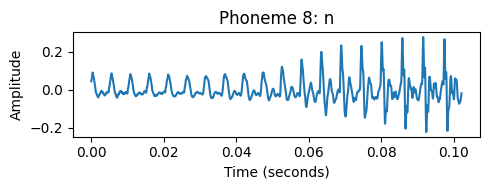

In [16]:
for i, (ph, start, end) in enumerate(phoneme_intervals[:8]):  # first 8 phonemes
    start_sample = int(start * sr)
    end_sample = int(end * sr)

    segment = signal[start_sample:end_sample]
    t = np.arange(len(segment)) / sr

    plt.figure(figsize=(5,2))
    plt.plot(t, segment)
    plt.title(f"Phoneme {i+1}: {ph}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


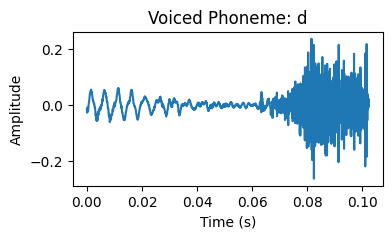

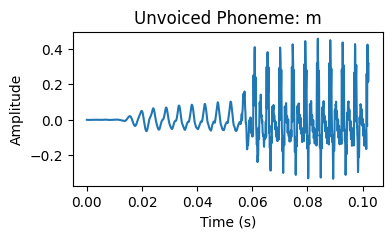

In [17]:
voiced_ph = phoneme_intervals[2]    # vowel example
unvoiced_ph = phoneme_intervals[0]  # consonant example

def plot_phoneme(ph_tuple, label):
    ph, start, end = ph_tuple
    seg = signal[int(start*sr):int(end*sr)]
    t = np.arange(len(seg)) / sr

    plt.figure(figsize=(4,2))
    plt.plot(t, seg)
    plt.title(f"{label}: {ph}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

plot_phoneme(voiced_ph, "Voiced Phoneme")
plot_phoneme(unvoiced_ph, "Unvoiced Phoneme")


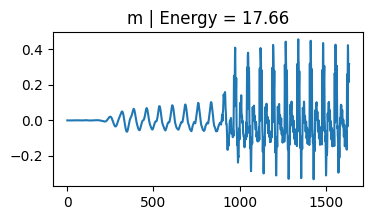

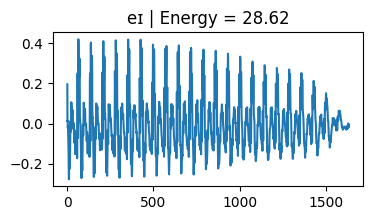

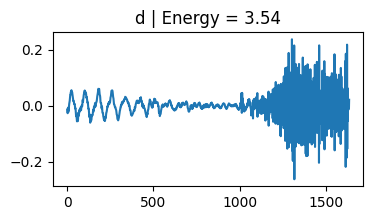

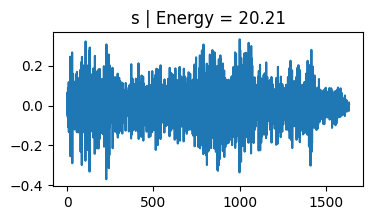

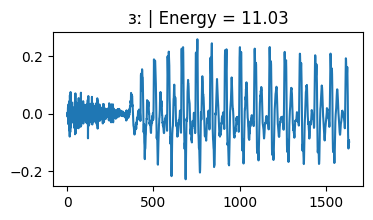

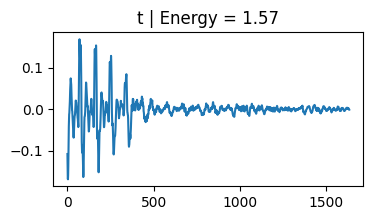

In [18]:
for ph, start, end in phoneme_intervals[:6]:
    seg = signal[int(start*sr):int(end*sr)]
    energy = np.sum(seg**2)

    plt.figure(figsize=(4,2))
    plt.plot(seg)
    plt.title(f"{ph} | Energy = {energy:.2f}")
    plt.show()
